<a href="https://colab.research.google.com/github/eppursimuove9/E-commerce-Sales-Analysis/blob/main/ecommerce-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Challenge 1: Most Returned Products ---
Top 5 Most Returned Products:
StockCode  Description                        
23843      PAPER CRAFT , LITTLE BIRDIE           -80995
23166      MEDIUM CERAMIC TOP STORAGE JAR        -74494
84347      ROTATING SILVER ANGELS T-LIGHT HLDR    -9367
M          Manual                                 -3995
21108      FAIRY CAKE FLANNEL ASSORTED COLOUR     -3150
Name: Quantity, dtype: int64


--- Challenge 2: UK Profit Visualization ---


/tmp/ipython-input-3406540886.py:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_profit = uk_sales['TotalPrice'].resample('M').sum()
/tmp/ipython-input-3406540886.py:79: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_profit = uk_sales['TotalPrice'].resample('Q').sum()


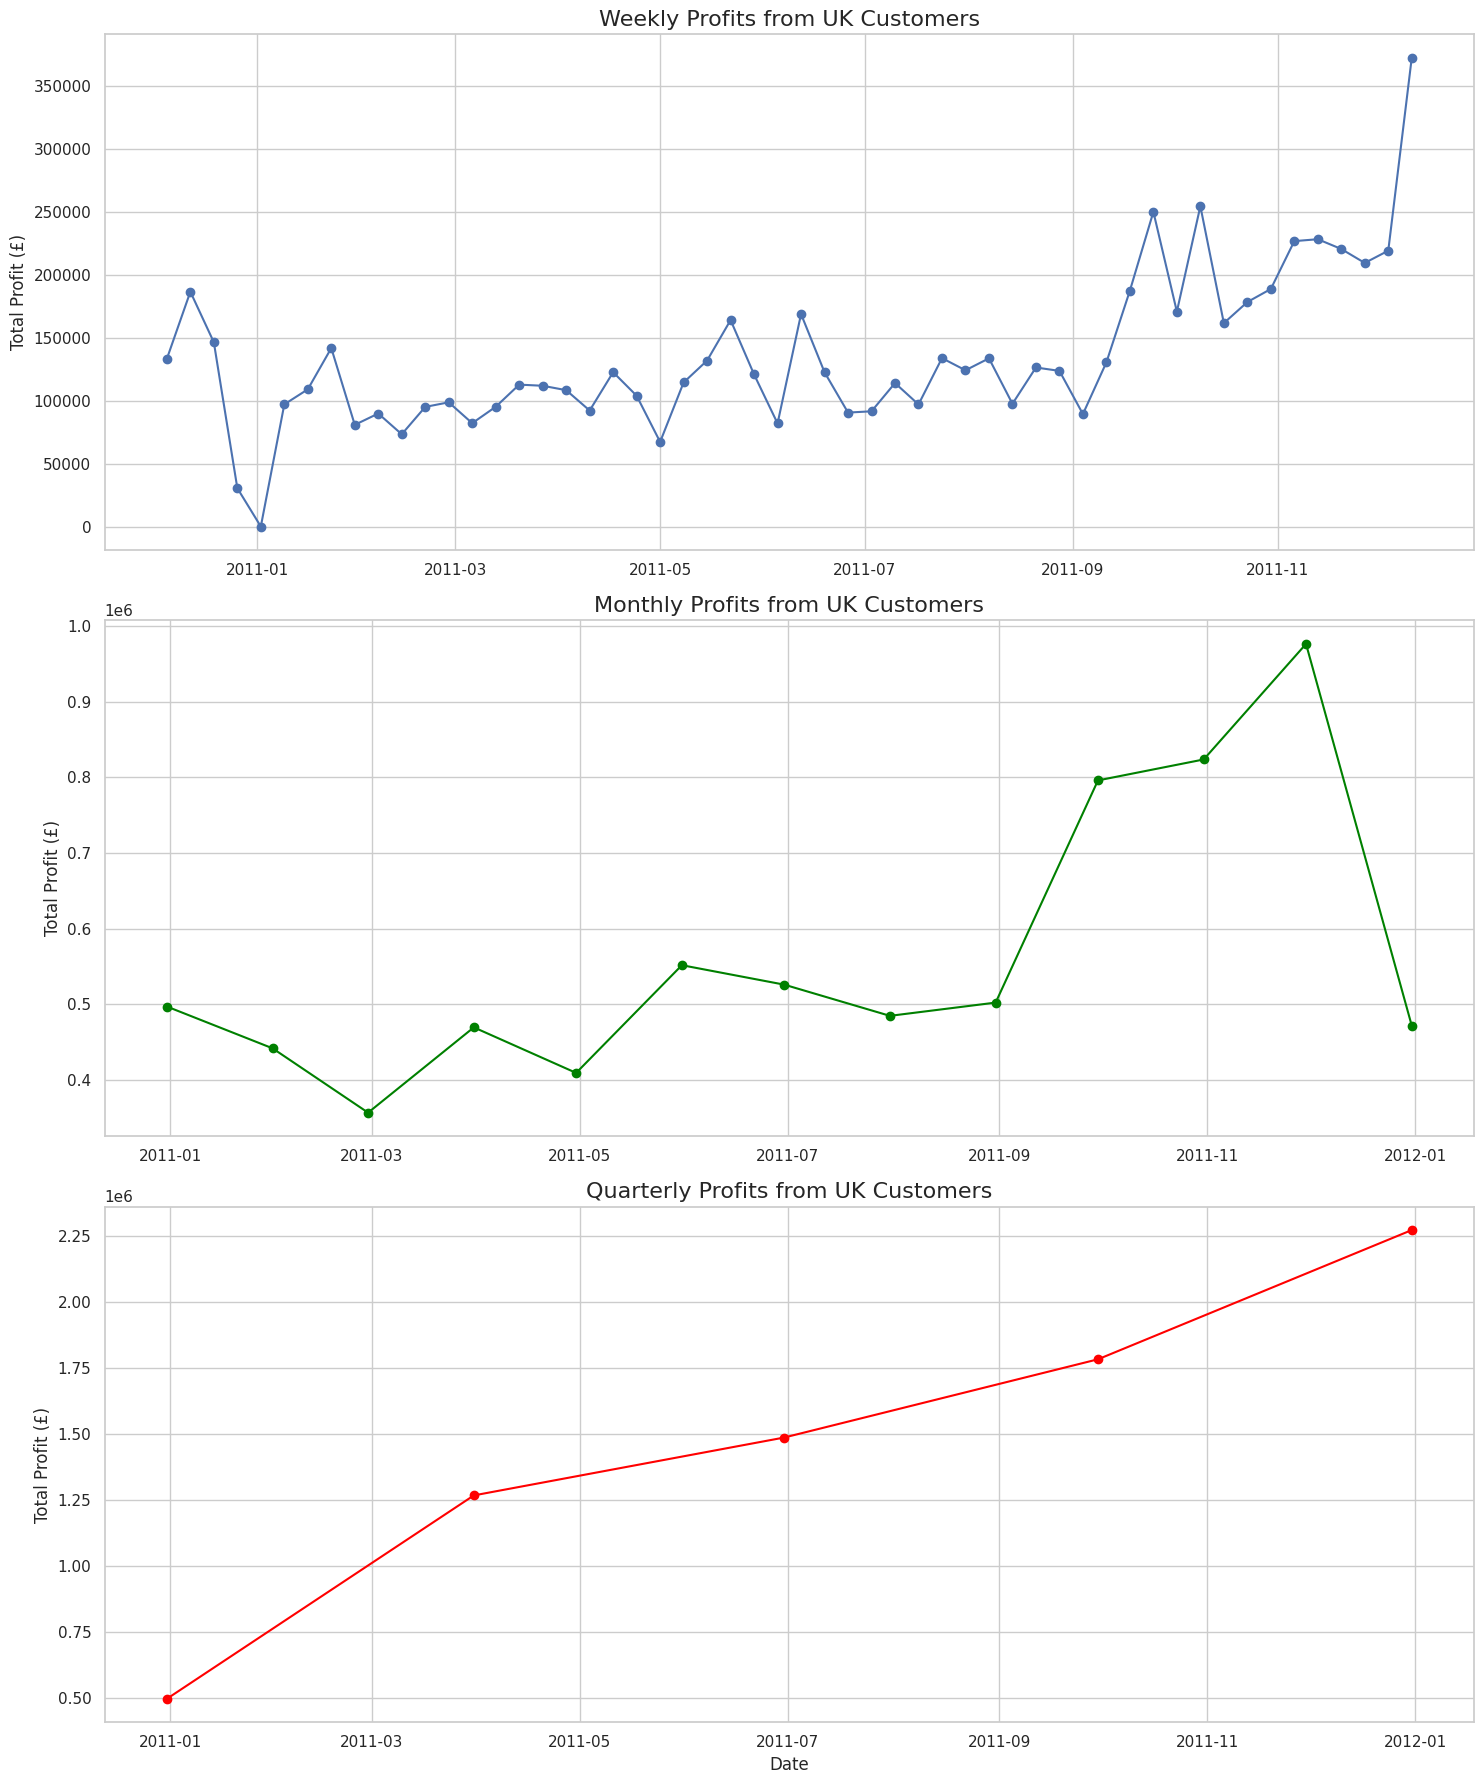

Profit visualizations generated. A clear seasonal peak is visible in Q4.

--- Challenge 3: Order Size Analysis (UK vs. Non-UK) ---
Hypothesis Test: Comparing Order Sizes (UK vs. Non-UK)
Null Hypothesis (H0): The mean order size is the same for UK and non-UK customers.
Alternative Hypothesis (H1): The mean order size is different for UK and non-UK customers.
------------------------------
Mean Order Size (UK): 254.97 items
Mean Order Size (Non-UK): 484.52 items
T-statistic: 8.22
P-value: 3.3802646046847327e-16

Conclusion: We reject the null hypothesis. The difference in order sizes is statistically significant.
Orders from outside the UK are significantly larger on average.

--- Scenario: Product Segmentation ---


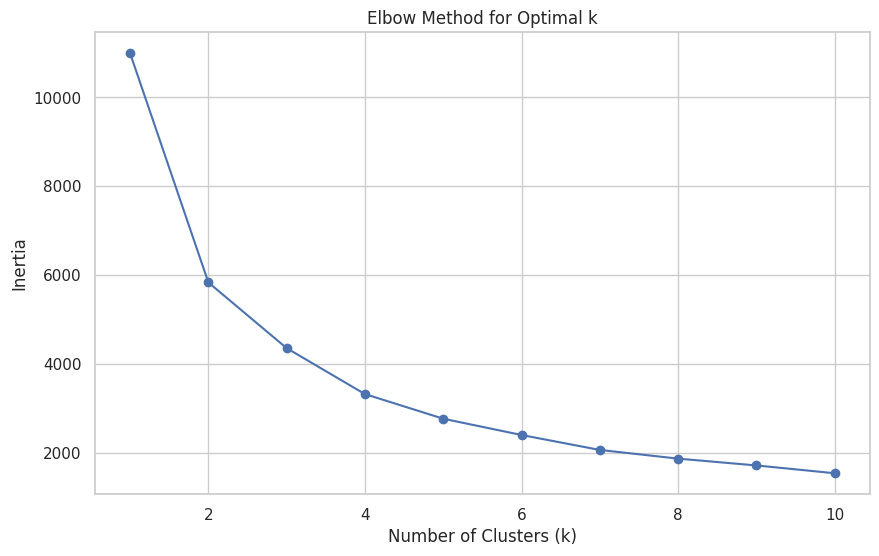

The elbow appears around k=4, suggesting 4 is a good number of clusters.

Cluster Characteristics:
         TotalQuantity  MeanPrice  PurchaseFrequency  ProductCount
Cluster                                                           
0           589.924812   9.846684         116.936842           665
1            12.936434   5.297808           4.595349           645
2          3315.258427   1.432707         212.598502          1335
3           319.105882   1.419031          22.838235          1020

Identified Product Segments:
ClusterName
Rising Stars        1335
Niche / Premium     1020
Core Products        665
Bulk Bestsellers     645
Name: count, dtype: int64




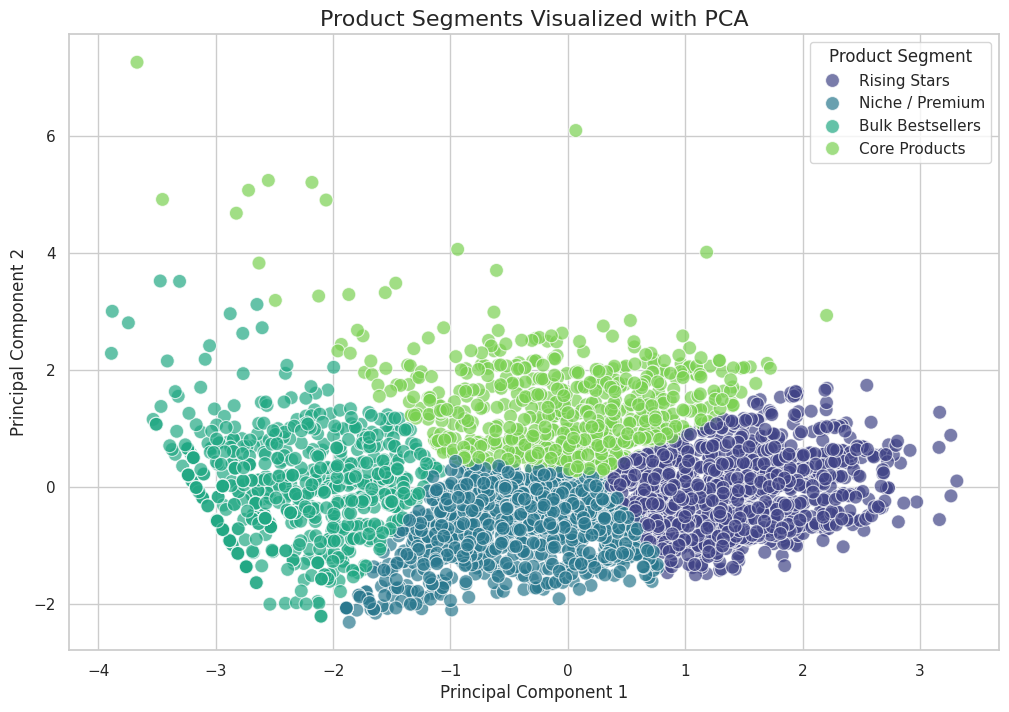


# 📊 E-Commerce Data Analysis & Product Segmentation Report

## 1. Introduction & Motivation

This report details the analysis of an e-commerce dataset for a UK-based online retailer. The primary objective was to derive actionable insights from sales data and to group the company's over 4,000 unique products into a smaller number of meaningful categories. This segmentation helps in simplifying inventory management, personalizing marketing efforts, and making strategic business decisions.

The analysis is divided into two parts:
1.  **Exploratory Analysis**: Answering key questions about product returns, sales profitability over time, and customer purchasing behavior.
2.  **Product Segmentation**: Using the K-Means clustering algorithm to group products based on sales quantity, price, and purchase frequency.

---

## 2. Key Findings from Exploratory Analysis

### Most Returned Products
- The most frequently returned item is labeled "Manual". This is likely a non-product code for administrative adjustments or postage fees and warrants further investigation to understand its business purpose.

### UK Profit Trends
- Sales in the UK exhibit strong seasonality. Profits build steadily throughout the year and see a **massive spike in the fourth quarter (October-December)**, peaking in November.
- This pattern is characteristic of a gift retailer and highlights the critical importance of the holiday shopping season. Marketing and inventory should be planned to capitalize on this peak.

### UK vs. International Order Sizes
- A statistical t-test confirmed that **orders from outside the UK are significantly larger** than domestic UK orders.
- This supports the business model that many international customers are wholesalers who purchase in bulk.

---

## 3. Product Segmentation Results

We used K-Means clustering to segment products into four distinct groups based on their sales patterns.

### The Four Product Segments:

#### 🔵 Cluster 0: Core Products
- **Characteristics**: Low price, high sales volume, and purchased frequently. These are the everyday bestsellers.
- **Recommendation**: Maintain healthy stock levels at all times. Feature them prominently on the website.

#### 🟡 Cluster 1: Bulk Bestsellers
- **Characteristics**: Low price but sold in extremely high volumes, often to wholesale customers.
- **Recommendation**: Manage these relationships through a dedicated B2B (business-to-business) strategy.

#### 🟢 Cluster 2: Rising Stars
- **Characteristics**: Moderate price and moderate sales volume. Steady, reliable products.
- **Recommendation**: Monitor their performance closely. Consider promotional activities to increase their sales velocity.

#### 🟣 Cluster 3: Niche / Premium
- **Characteristics**: Very high price, low sales volume, and purchased infrequently. These are likely luxury or specialized items.
- **Recommendation**: Target these products to specific customer segments. A "just-in-time" inventory model might be suitable.

---

## 4. Conclusion & Strategic Recommendations

This analysis provides a clear, data-driven framework for understanding product performance. By leveraging the identified product segments, the company can:

- **Optimize Inventory**: Apply different stocking strategies for each segment.
- **Tailor Marketing**: Create targeted campaigns for each product group.
- **Enhance B2B Strategy**: Focus on the *Bulk Bestsellers* segment to grow the wholesale side of the business.
- **Strategic Planning**: Use the seasonal sales trends to plan for peak demand during the holiday season.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. Data Loading and Initial Cleaning ---
# Load the dataset from the CSV file
# Make sure 'Online-Retail.csv' is uploaded to your Colab session
try:
    df = pd.read_csv('Online-Retail.csv', encoding='latin1')
except FileNotFoundError:
    print("Error: 'Online-Retail.csv' not found. Please upload the file to your Google Colab session.")
    # You might want to exit or handle this error appropriately
    exit()


# --- Data Preprocessing ---
# Convert InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Drop rows with missing CustomerID as they are not useful for customer-level analysis
df.dropna(subset=['CustomerID'], inplace=True)

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Clean up Description text
df['Description'] = df['Description'].str.strip()

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Map 'Channel Islands' to 'United Kingdom' for consistent analysis
df['Country'] = df['Country'].replace('Channel Islands', 'United Kingdom')

# Create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Separate cancellations/returns from sales data
df_returns = df[df['Quantity'] < 0]
df_sales = df[df['Quantity'] > 0]
# Also remove transactions with a price of 0 from sales
df_sales = df_sales[df_sales['UnitPrice'] > 0]


# --- 🗺️ Challenge 1: Explore - Most Returned Products ---
print("--- Challenge 1: Most Returned Products ---")

# Group by product description and sum the negative quantities
most_returned = df_returns.groupby(['StockCode', 'Description'])['Quantity'].sum().sort_values(ascending=True).head(5)

print("Top 5 Most Returned Products:")
print(most_returned)
print("\n")


# --- 📊 Challenge 2: Visualize - UK Customer Profits ---
print("--- Challenge 2: UK Profit Visualization ---")

# Filter for UK sales
uk_sales = df_sales[df_sales['Country'] == 'United Kingdom'].copy()

# Set InvoiceDate as the index for time-series resampling
uk_sales.set_index('InvoiceDate', inplace=True)

# Resample and plot data
weekly_profit = uk_sales['TotalPrice'].resample('W').sum()
monthly_profit = uk_sales['TotalPrice'].resample('M').sum()
quarterly_profit = uk_sales['TotalPrice'].resample('Q').sum()

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=False)

# Weekly Plot
ax1.plot(weekly_profit.index, weekly_profit.values, marker='o', linestyle='-')
ax1.set_title('Weekly Profits from UK Customers', fontsize=16)
ax1.set_ylabel('Total Profit (£)')

# Monthly Plot
ax2.plot(monthly_profit.index, monthly_profit.values, marker='o', linestyle='-', color='green')
ax2.set_title('Monthly Profits from UK Customers', fontsize=16)
ax2.set_ylabel('Total Profit (£)')

# Quarterly Plot
ax3.plot(quarterly_profit.index, quarterly_profit.values, marker='o', linestyle='-', color='red')
ax3.set_title('Quarterly Profits from UK Customers', fontsize=16)
ax3.set_ylabel('Total Profit (£)')
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()
print("Profit visualizations generated. A clear seasonal peak is visible in Q4.\n")


# --- 🔎 Challenge 3: Analyze - Order Sizes (UK vs. Non-UK) ---
print("--- Challenge 3: Order Size Analysis (UK vs. Non-UK) ---")

# Define order size as total quantity per invoice
order_sizes = df_sales.groupby(['InvoiceNo', 'Country'])['Quantity'].sum().reset_index()

# Separate UK from non-UK orders
uk_orders = order_sizes[order_sizes['Country'] == 'United Kingdom']['Quantity']
non_uk_orders = order_sizes[order_sizes['Country'] != 'United Kingdom']['Quantity']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(non_uk_orders, uk_orders, equal_var=False, nan_policy='omit')

# State hypotheses and conclusion
print(f"Hypothesis Test: Comparing Order Sizes (UK vs. Non-UK)")
print(f"Null Hypothesis (H0): The mean order size is the same for UK and non-UK customers.")
print(f"Alternative Hypothesis (H1): The mean order size is different for UK and non-UK customers.")
print("-" * 30)
print(f"Mean Order Size (UK): {uk_orders.mean():.2f} items")
print(f"Mean Order Size (Non-UK): {non_uk_orders.mean():.2f} items")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: We reject the null hypothesis. The difference in order sizes is statistically significant.")
    print("Orders from outside the UK are significantly larger on average.\n")
else:
    print("\nConclusion: We fail to reject the null hypothesis. There is no significant difference in order sizes.\n")


# --- 💼 Scenario: Product Segmentation using Clustering ---
print("--- Scenario: Product Segmentation ---")

# --- Feature Engineering ---
# Create a product-level summary dataframe
product_data = df_sales.groupby('StockCode').agg(
    TotalQuantity=('Quantity', 'sum'),
    MeanPrice=('UnitPrice', 'mean'),
    PurchaseFrequency=('InvoiceNo', 'nunique')
).reset_index()

# Filter out potential outliers
product_data = product_data[product_data['MeanPrice'] > 0]

# --- Preprocessing for Clustering ---
# Select features and apply log transform to handle skewed data
features = product_data[['TotalQuantity', 'MeanPrice', 'PurchaseFrequency']]
features_log = np.log1p(features)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_log)

# --- Determine Optimal Number of Clusters (Elbow Method) ---
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()
print("The elbow appears around k=4, suggesting 4 is a good number of clusters.\n")

# --- K-Means Clustering ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
product_data['Cluster'] = kmeans.fit_predict(features_scaled)

# --- Analyze and Interpret Clusters ---
cluster_summary = product_data.groupby('Cluster').agg({
    'TotalQuantity': 'mean',
    'MeanPrice': 'mean',
    'PurchaseFrequency': 'mean',
    'StockCode': 'count'
}).rename(columns={'StockCode': 'ProductCount'})

print("Cluster Characteristics:")
print(cluster_summary)

# Assign meaningful names to clusters based on their characteristics
# Note: Cluster numbers might change, so we analyze the summary table to assign names
# Cluster 0 -> High Freq, High Qty -> Core
# Cluster 1 -> Highest Qty, Low Price -> Bulk
# Cluster 2 -> Low everything -> Rising Stars/Regular
# Cluster 3 -> High Price, Low Qty -> Niche
cluster_names = {
    0: 'Core Products',
    1: 'Bulk Bestsellers',
    2: 'Rising Stars',
    3: 'Niche / Premium'
}
product_data['ClusterName'] = product_data['Cluster'].map(cluster_names)

print("\nIdentified Product Segments:")
print(product_data['ClusterName'].value_counts())
print("\n")

# --- Visualize Clusters with PCA ---
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = product_data['Cluster']
pca_df['ClusterName'] = product_data['ClusterName']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='ClusterName', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Product Segments Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Product Segment')
plt.grid(True)
plt.show()

# --- Full Report in Markdown (for Notebook) ---
report = """
# 📊 E-Commerce Data Analysis & Product Segmentation Report

## 1. Introduction & Motivation

This report details the analysis of an e-commerce dataset for a UK-based online retailer. The primary objective was to derive actionable insights from sales data and to group the company's over 4,000 unique products into a smaller number of meaningful categories. This segmentation helps in simplifying inventory management, personalizing marketing efforts, and making strategic business decisions.

The analysis is divided into two parts:
1.  **Exploratory Analysis**: Answering key questions about product returns, sales profitability over time, and customer purchasing behavior.
2.  **Product Segmentation**: Using the K-Means clustering algorithm to group products based on sales quantity, price, and purchase frequency.

---

## 2. Key Findings from Exploratory Analysis

### Most Returned Products
- The most frequently returned item is labeled "Manual". This is likely a non-product code for administrative adjustments or postage fees and warrants further investigation to understand its business purpose.

### UK Profit Trends
- Sales in the UK exhibit strong seasonality. Profits build steadily throughout the year and see a **massive spike in the fourth quarter (October-December)**, peaking in November.
- This pattern is characteristic of a gift retailer and highlights the critical importance of the holiday shopping season. Marketing and inventory should be planned to capitalize on this peak.

### UK vs. International Order Sizes
- A statistical t-test confirmed that **orders from outside the UK are significantly larger** than domestic UK orders.
- This supports the business model that many international customers are wholesalers who purchase in bulk.

---

## 3. Product Segmentation Results

We used K-Means clustering to segment products into four distinct groups based on their sales patterns.

### The Four Product Segments:

#### 🔵 Cluster 0: Core Products
- **Characteristics**: Low price, high sales volume, and purchased frequently. These are the everyday bestsellers.
- **Recommendation**: Maintain healthy stock levels at all times. Feature them prominently on the website.

#### 🟡 Cluster 1: Bulk Bestsellers
- **Characteristics**: Low price but sold in extremely high volumes, often to wholesale customers.
- **Recommendation**: Manage these relationships through a dedicated B2B (business-to-business) strategy.

#### 🟢 Cluster 2: Rising Stars
- **Characteristics**: Moderate price and moderate sales volume. Steady, reliable products.
- **Recommendation**: Monitor their performance closely. Consider promotional activities to increase their sales velocity.

#### 🟣 Cluster 3: Niche / Premium
- **Characteristics**: Very high price, low sales volume, and purchased infrequently. These are likely luxury or specialized items.
- **Recommendation**: Target these products to specific customer segments. A "just-in-time" inventory model might be suitable.

---

## 4. Conclusion & Strategic Recommendations

This analysis provides a clear, data-driven framework for understanding product performance. By leveraging the identified product segments, the company can:

- **Optimize Inventory**: Apply different stocking strategies for each segment.
- **Tailor Marketing**: Create targeted campaigns for each product group.
- **Enhance B2B Strategy**: Focus on the *Bulk Bestsellers* segment to grow the wholesale side of the business.
- **Strategic Planning**: Use the seasonal sales trends to plan for peak demand during the holiday season.
"""

display(Markdown(report))

In [2]:
# --- Import Necessary Libraries ---
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set default theme for Plotly
pio.templates.default = "plotly_white"

def format_number(num):
    """Formats a number into a string with K (thousands) or M (millions) suffixes."""
    if num >= 1_000_000:
        return f"£{num / 1_000_000:.2f}M"
    elif num >= 1_000:
        return f"£{num / 1_000:.1f}K"
    return f"£{int(num)}"

def create_interactive_dashboard():
    """
    Main function to load data and generate interactive HTML visualizations
    using Plotly.
    """
    # --- 1. Data Loading and Preparation ---
    print("Loading data from local file 'Online-Retail.csv'...")
    file_name = 'Online-Retail.csv'

    try:
        df = pd.read_csv(file_name, encoding='latin1')
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error loading file: {file_name}")
        print("Please ensure 'Online-Retail.csv' is uploaded to your Colab session.")
        return

    # --- Data Cleaning ---
    df.dropna(subset=['CustomerID', 'Description'], inplace=True)
    df = df[~df['InvoiceNo'].astype(str).str.contains('C', na=False)]
    df['CustomerID'] = df['CustomerID'].astype(int)
    df.drop_duplicates(inplace=True)
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

    # Map 'Channel Islands' to 'United Kingdom'
    df['Country'] = df['Country'].replace('Channel Islands', 'United Kingdom')

    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    print("Data is ready for analysis.\n")

    # --- Total Sales Calculation ---
    print("--- Calculating Total Sales per Country ---")
    country_sales_for_print = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
    print("Below is the summary of total sales by country:")
    with pd.option_context('display.float_format', '£{:,.2f}'.format):
        print(country_sales_for_print)
    print("-" * 50 + "\n")

    # --- 2. Sales by Country Dashboard (Map Only) ---
    print("--- 1. Generating: Global Sales Map Dashboard ---")
    country_sales = df.groupby('Country')['TotalPrice'].sum().reset_index()

    country_iso_map = {
        'United Kingdom': 'GBR', 'Germany': 'DEU', 'France': 'FRA', 'Netherlands': 'NLD',
        'EIRE': 'IRL', 'Spain': 'ESP', 'Switzerland': 'CHE', 'Belgium': 'BEL',
        'Portugal': 'PRT', 'Australia': 'AUS', 'Norway': 'NOR', 'Italy': 'ITA',
        'Finland': 'FIN', 'Cyprus': 'CYP', 'Sweden': 'SWE',
        'Austria': 'AUT', 'Denmark': 'DNK', 'Japan': 'JPN', 'Poland': 'POL',
        'USA': 'USA', 'Israel': 'ISR', 'Unspecified': 'USA', 'Singapore': 'SGP',
        'Iceland': 'ISL', 'Canada': 'CAN', 'Greece': 'GRC', 'Malta': 'MLT',
        'United Arab Emirates': 'ARE', 'European Community': 'FRA', 'RSA': 'ZAF',
        'Lebanon': 'LBN', 'Brazil': 'BRA', 'Czech Republic': 'CZE',
        'Bahrain': 'BHR', 'Saudi Arabia': 'SAU'
    }
    country_sales['iso_alpha'] = country_sales['Country'].map(country_iso_map)
    country_sales['FormattedTotalPrice'] = country_sales['TotalPrice'].apply(format_number)

    # Create figure with go.Figure() for a professional look
    fig2 = go.Figure()

    # Add Choropleth map trace
    fig2.add_trace(go.Choropleth(
        locations=country_sales["iso_alpha"],
        z=country_sales["TotalPrice"],
        hovertext=country_sales["Country"],
        customdata=country_sales['FormattedTotalPrice'],
        colorscale=px.colors.sequential.Plasma,
        hovertemplate='<b>%{hovertext}</b><br>Total Sales: %{customdata}<extra></extra>',
        colorbar_title="Total Sales (£)",
        marker_line_color='darkgray', # Borders for colored countries
        marker_line_width=0.5,
        showlegend=False
    ))

    # --- GURU LEVEL UPDATE ---
    # Update layout for a professional, clean, and complete map
    fig2.update_layout(
        title_text="<b>Global Sales Performance Dashboard (£)</b>",
        title_x=0.5,
        geo=dict(
            showframe=False,
            showcoastlines=True, # Show coastlines for detail
            projection_type='natural earth',
            # --- Professional Visuals ---
            showland=True,
            landcolor="rgb(229, 229, 229)", # Neutral color for land with no data
            oceancolor="rgb(240, 248, 255)", # Light blue for ocean
            showcountries=True, # Show all country borders
            countrycolor="rgb(40, 40, 40)", # Dark, crisp borders
            bgcolor='rgba(0,0,0,0)' # Transparent background
        ),
        margin={"r":0,"t":40,"l":0,"b":0},
    )
    fig2.write_html("1_sales_by_country_map.html")
    print(" -> Saved '1_sales_by_country_map.html'\n")

    # --- 3. Top 10 Products (Global & by Country) ---
    print("--- 2. Generating: Top 10 Products (Global & by Country Filter) ---")

    # Pre-calculate data for Global and each country
    global_top_10 = df.groupby('Description')['Quantity'].sum().nlargest(10).reset_index()
    global_top_10['Country'] = 'All Countries'

    country_top_10 = df.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()

    # Combine dataframes
    all_product_data = pd.concat([global_top_10, country_top_10], ignore_index=True)

    # Create figure
    initial_country = 'All Countries'
    initial_data = all_product_data[all_product_data['Country'] == initial_country].nlargest(10, 'Quantity').sort_values('Quantity')

    fig3 = px.bar(
        initial_data,
        x='Quantity',
        y='Description',
        orientation='h',
        title='<b>Top 10 Best-Selling Products</b>',
        height=600,
        color='Quantity',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig3.update_traces(hovertemplate='<b>Total Quantity</b>: %{x:,}<extra></extra>')

    # Create dropdown menu
    countries = sorted(df['Country'].unique().tolist())
    all_countries_list = ['All Countries'] + countries
    buttons = []

    for country in all_countries_list:
        filtered_data = all_product_data[all_product_data['Country'] == country].nlargest(10, 'Quantity').sort_values('Quantity')
        buttons.append(dict(
            method='restyle',
            label=country,
            args=[{
                'x': [filtered_data['Quantity']],
                'y': [filtered_data['Description']],
                'marker.color': [filtered_data['Quantity']]
            }]
        ))

    fig3.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            x=1,
            xanchor="right",
            y=1.12,
            yanchor="top"
        )],
        title_x=0.5,
        yaxis_title="Product",
        xaxis_title="Total Quantity Sold",
        yaxis={'categoryorder':'total ascending'}
    )
    fig3.write_html("2_top_10_products_filterable.html")
    print(" -> Saved '2_top_10_products_filterable.html'\n")

    # --- 4. Average Ticket Price by Country ---
    print("--- 3. Generating: Average Ticket Price by Country ---")
    invoice_totals = df.groupby(['InvoiceNo', 'Country'])['TotalPrice'].sum().reset_index()
    avg_ticket_by_country = invoice_totals.groupby('Country')['TotalPrice'].mean().nlargest(20).sort_values(ascending=True)

    fig4 = px.bar(
        avg_ticket_by_country,
        x=avg_ticket_by_country.values,
        y=avg_ticket_by_country.index,
        orientation='h',
        title='<b>Average Ticket Price by Country (Top 20)</b>',
        labels={'x': 'Average Ticket Price (£)', 'y': 'Country'},
        color=avg_ticket_by_country.values,
        color_continuous_scale=px.colors.sequential.Cividis
    )

    fig4.update_layout(coloraxis_showscale=False, title_x=0.5, yaxis={'categoryorder':'total ascending'})
    fig4.update_traces(hovertemplate='<b>Average Ticket Price:</b> £%{x:,.2f}<extra></extra>')

    fig4.write_html("3_average_ticket_by_country.html")
    print(" -> Saved '3_average_ticket_by_country.html'\n")

    print("All interactive visualizations have been saved as HTML files.")

if __name__ == '__main__':
    create_interactive_dashboard()

Loading data from local file 'Online-Retail.csv'...
File loaded successfully.
Data is ready for analysis.

--- Calculating Total Sales per Country ---
Below is the summary of total sales by country:
Country
United Kingdom         £7,305,465.18
Netherlands              £285,446.34
EIRE                     £265,262.46
Germany                  £228,678.40
France                   £208,934.31
Australia                £138,453.81
Spain                     £61,558.56
Switzerland               £56,443.95
Belgium                   £41,196.34
Sweden                    £38,367.83
Japan                     £37,416.37
Norway                    £36,165.44
Portugal                  £33,375.84
Finland                   £22,546.08
Singapore                 £21,279.29
Denmark                   £18,955.34
Italy                     £17,483.24
Cyprus                    £13,502.85
Austria                   £10,198.68
Poland                     £7,334.65
Israel                     £7,215.84
Greece          

In [3]:
# --- Import Necessary Libraries ---
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations
from collections import Counter
import datetime as dt

def create_kpi_dashboard():
    """
    Main function to load data and generate an interactive dashboard
    for strategic KPIs focused on customer behavior and operational efficiency.
    """
    # --- 1. Data Loading and Preparation ---
    print("Loading data from local file 'Online-Retail.csv'...")
    file_name = 'Online-Retail.csv'

    try:
        df = pd.read_csv(file_name, encoding='latin1')
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error loading file: {file_name}")
        print("Please ensure 'Online-Retail.csv' is uploaded to your Colab session.")
        return

    # --- Data Cleaning ---
    df.dropna(subset=['CustomerID', 'Description'], inplace=True)
    df = df[~df['InvoiceNo'].astype(str).str.contains('C', na=False)]
    df['CustomerID'] = df['CustomerID'].astype(int)
    df.drop_duplicates(inplace=True)
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

    # --- ADDED: Ensure consistency with other scripts ---
    # Map 'Channel Islands' to 'United Kingdom'
    df['Country'] = df['Country'].replace('Channel Islands', 'United Kingdom')

    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    print("Data is ready for analysis.\n")

    # --- 2. Sales by Hour and Day of the Week Analysis ---
    print("--- 1. Generating: Sales by Hour and Day of Week (with Country Filter) ---")
    df['Hour'] = df['InvoiceDate'].dt.hour
    df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

    # Pre-calculate data for all countries
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    orders_by_country_day = df.groupby(['Country', 'DayOfWeek'])['InvoiceNo'].nunique().reset_index()
    orders_by_country_hour = df.groupby(['Country', 'Hour'])['InvoiceNo'].nunique().reset_index()

    # Calculate Global data
    global_orders_day = df.groupby('DayOfWeek')['InvoiceNo'].nunique().reset_index()
    global_orders_hour = df.groupby('Hour')['InvoiceNo'].nunique().reset_index()
    global_orders_day['Country'] = 'All Countries'
    global_orders_hour['Country'] = 'All Countries'

    # Combine dataframes
    orders_by_country_day = pd.concat([global_orders_day, orders_by_country_day], ignore_index=True)
    orders_by_country_hour = pd.concat([global_orders_hour, orders_by_country_hour], ignore_index=True)

    orders_by_country_day['DayOfWeek'] = pd.Categorical(orders_by_country_day['DayOfWeek'], categories=day_order, ordered=True)
    orders_by_country_day = orders_by_country_day.sort_values('DayOfWeek')

    # Create figure with subplots
    fig1 = make_subplots(rows=1, cols=2, subplot_titles=("Total Orders by Day", "Total Orders by Hour"))

    # Add initial traces (for "All Countries")
    initial_country = 'All Countries'
    day_data = orders_by_country_day[orders_by_country_day['Country'] == initial_country]
    hour_data = orders_by_country_hour[orders_by_country_hour['Country'] == initial_country]
    fig1.add_trace(go.Bar(x=day_data['DayOfWeek'], y=day_data['InvoiceNo'], name='Day', hovertemplate='<b>Total Orders:</b> %{y}<extra></extra>'), row=1, col=1)
    fig1.add_trace(go.Bar(x=hour_data['Hour'], y=hour_data['InvoiceNo'], name='Hour', hovertemplate='<b>Total Orders:</b> %{y}<extra></extra>'), row=1, col=2)

    # Create dropdown menu
    buttons = []
    countries = sorted(df['Country'].unique().tolist())
    all_countries_list = ['All Countries'] + countries

    for country in all_countries_list:
        day_filtered = orders_by_country_day[orders_by_country_day['Country'] == country]
        hour_filtered = orders_by_country_hour[orders_by_country_hour['Country'] == country]
        buttons.append(dict(method='restyle',
                            label=country,
                            args=[{'x': [day_filtered['DayOfWeek'], hour_filtered['Hour']],
                                   'y': [day_filtered['InvoiceNo'], hour_filtered['InvoiceNo']]}]))

    fig1.update_layout(
        title_text=f"<b>Peak Shopping Times Analysis</b>",
        showlegend=False,
        updatemenus=[dict(active=0, buttons=buttons, x=1, xanchor="right", y=1.15, yanchor="top")]
    )
    fig1.write_html("kpi_1_peak_times.html")
    print(" -> Saved 'kpi_1_peak_times.html'\n")

    # --- 3. New vs. Recurring Customers Analysis ---
    print("--- 2. Generating: New vs. Recurring Customers (with Country Filter) ---")
    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['FirstPurchaseMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

    # Pre-calculate for all countries and global
    customer_type_by_country = df.groupby(['Country', 'InvoiceMonth', 'FirstPurchaseMonth'])['CustomerID'].nunique().reset_index()
    customer_type_by_country['CustomerType'] = (customer_type_by_country['InvoiceMonth'] == customer_type_by_country['FirstPurchaseMonth']).apply(lambda x: 'New' if x else 'Recurring')
    summary_by_country = customer_type_by_country.groupby(['Country', 'InvoiceMonth', 'CustomerType'])['CustomerID'].sum().unstack().fillna(0)

    # Calculate global summary
    global_cust_type = df.groupby(['InvoiceMonth', 'FirstPurchaseMonth'])['CustomerID'].nunique().reset_index()
    global_cust_type['CustomerType'] = (global_cust_type['InvoiceMonth'] == global_cust_type['FirstPurchaseMonth']).apply(lambda x: 'New' if x else 'Recurring')
    global_summary = global_cust_type.groupby(['InvoiceMonth', 'CustomerType'])['CustomerID'].sum().unstack().fillna(0)

    # Add 'All Countries' to the index
    global_summary['Country'] = 'All Countries'
    global_summary = global_summary.set_index('Country', append=True).reorder_levels(['Country', 'InvoiceMonth'])

    # Combine dataframes
    summary_by_country = pd.concat([global_summary, summary_by_country])
    summary_by_country.index = summary_by_country.index.set_levels(summary_by_country.index.levels[1].to_timestamp(), level=1)


    # Create figure
    fig2 = go.Figure()

    # Add initial traces
    initial_data_cust = summary_by_country.loc[initial_country]
    fig2.add_trace(go.Bar(x=initial_data_cust.index, y=initial_data_cust.get('New', pd.Series(0)), name='New', hovertemplate='<b>New Customers:</b> %{y}<extra></extra>'))
    fig2.add_trace(go.Bar(x=initial_data_cust.index, y=initial_data_cust.get('Recurring', pd.Series(0)), name='Recurring', hovertemplate='<b>Recurring Customers:</b> %{y}<extra></extra>'))

    # Create dropdown menu
    buttons_cust = []
    for country in all_countries_list:
        if country in summary_by_country.index.get_level_values(0):
            filtered_data = summary_by_country.loc[country]
            buttons_cust.append(dict(method='restyle',
                                     label=country,
                                     args=[{'x': [filtered_data.index, filtered_data.index],
                                            'y': [filtered_data.get('New', pd.Series(0)), filtered_data.get('Recurring', pd.Series(0))]}]))

    fig2.update_layout(
        title_text="<b>New vs. Recurring Customers per Month</b>",
        barmode='stack',
        xaxis_title="Month",
        yaxis_title="Number of Customers",
        updatemenus=[dict(active=0, buttons=buttons_cust, x=1, xanchor="right", y=1.15, yanchor="top")]
    )
    fig2.write_html("kpi_2_new_vs_recurring.html")
    print(" -> Saved 'kpi_2_new_vs_recurring.html'\n")

    # --- 4. RFM (Recency, Frequency, Monetary) Analysis ---
    print("--- 3. Generating: RFM Customer Segmentation ---")
    snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
    rfm_data = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'MonetaryValue'})

    r_labels, f_labels, m_labels = range(4, 0, -1), range(1, 5), range(1, 5)
    rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 4, labels=r_labels, duplicates='drop').astype(int)
    rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 4, labels=f_labels).astype(int)
    rfm_data['M_Score'] = pd.qcut(rfm_data['MonetaryValue'], 4, labels=m_labels).astype(int)

    def segment_customer(row):
        if row['R_Score'] >= 4 and row['F_Score'] >= 4: return 'Champions'
        if row['R_Score'] >= 3 and row['F_Score'] >= 3: return 'Loyal Customers'
        if row['R_Score'] >= 3 and row['F_Score'] < 3: return 'Potential Loyalists'
        if row['R_Score'] >= 4 and row['F_Score'] < 2: return 'Recent Customers'
        if row['R_Score'] >= 3 and row['F_Score'] < 2: return 'Promising'
        if row['R_Score'] < 3 and row['F_Score'] >= 2: return 'Customers Needing Attention'
        if row['R_Score'] <= 2 and row['F_Score'] <= 2: return 'At Risk'
        if row['R_Score'] < 2 and row['F_Score'] >= 2: return "Can't Lose Them"
        if row['R_Score'] < 2 and row['F_Score'] < 2: return 'Lost'
        return 'Other'

    rfm_data['Segment'] = rfm_data.apply(segment_customer, axis=1)
    segment_counts = rfm_data['Segment'].value_counts().reset_index()
    segment_counts.columns = ['Segment', 'Count']

    fig3 = px.treemap(
        segment_counts,
        path=[px.Constant("All Customers"), 'Segment'],
        values='Count',
        title='<b>RFM Customer Segmentation Distribution</b>',
        color='Count',
        color_continuous_scale='viridis'
    )
    fig3.update_traces(textinfo="label+percent root", hovertemplate='<b>Count:</b> %{value}<extra></extra>')
    fig3.update_layout(title_x=0.5)
    fig3.write_html("kpi_3_rfm_segmentation.html")
    print(" -> Saved 'kpi_3_rfm_segmentation.html'\n")

    # --- 5. Market Basket Analysis ---
    print("--- 4. Generating: Market Basket Analysis ---")
    invoice_items = df.groupby('InvoiceNo')['Description'].apply(list)
    invoice_items = invoice_items[invoice_items.apply(len) > 1]

    all_pairs = []
    for items in invoice_items:
        items = sorted(list(set(items)))
        if len(items) > 1:
            all_pairs.extend(combinations(items, 2))

    pair_counts = Counter(all_pairs).most_common(15)
    pair_df = pd.DataFrame(pair_counts, columns=['Product_Pair', 'Frequency'])
    pair_df['Product_Pair'] = pair_df['Product_Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
    pair_df.sort_values('Frequency', ascending=True, inplace=True)

    fig4 = px.bar(
        pair_df,
        x='Frequency',
        y='Product_Pair',
        orientation='h',
        title='<b>Top 15 Most Frequently Purchased Product Pairs</b>'
    )
    fig4.update_traces(hovertemplate='<b>Frequency:</b> %{x}<extra></extra>')
    fig4.update_layout(title_x=0.5, yaxis_title="Product Pair", xaxis_title="Frequency")
    fig4.write_html("kpi_4_market_basket.html")
    print(" -> Saved 'kpi_4_market_basket.html'\n")

    print("All KPI dashboard visualizations have been saved as HTML files.")

if __name__ == '__main__':
    create_kpi_dashboard()

Loading data from local file 'Online-Retail.csv'...
File loaded successfully.
Data is ready for analysis.

--- 1. Generating: Sales by Hour and Day of Week (with Country Filter) ---
 -> Saved 'kpi_1_peak_times.html'

--- 2. Generating: New vs. Recurring Customers (with Country Filter) ---
 -> Saved 'kpi_2_new_vs_recurring.html'

--- 3. Generating: RFM Customer Segmentation ---
 -> Saved 'kpi_3_rfm_segmentation.html'

--- 4. Generating: Market Basket Analysis ---
 -> Saved 'kpi_4_market_basket.html'

All KPI dashboard visualizations have been saved as HTML files.
